# SciPy

[SciPy](https://scipy.org/) is a collection of numerical algorithms with python interfaces.  In many cases, these interfaces are wrappers around standard numerical libraries that have been developed in the community and are used with other languages.  Usually detailed references are available to explain the implementation.

````{note}
There are many subpackages generally, you load the subpackages separately, e.g.

```
from scipy import linalg, optimize
```
then you have access to the methods in those namespaces
````

```{important}
One thing to keep in mind---all numerical methods have strengths and weaknesses, and make assumptions.  You should always do some research into the method to understand what it is doing.
```

```{tip}
It is also always a good idea to run a new method on some test where you know the answer, to make sure it is behaving as expected.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Integration

we'll do some integrals of the form

$$I = \int_a^b f(x) dx$$

We can imagine two situations:
* our function $f(x)$ is given by an analytic expression.  This gives us the freedom to pick our integration points, and in general can allow us to optimize our result and get high accuracy
* our function $f(x)$ is defined on at a set of (possibly regular spaced) points.  

```{note}
In numerical analysis, the term [quadrature](https://en.wikipedia.org/wiki/Numerical_integration) is used to describe any integration method that represents the integral as the weighted sum of a discrete number of points.
```

In [2]:
from scipy import integrate
#help(integrate)

Let's consider integrating

$$I = \int_0^{2\pi} \sin^2(x) dx$$

[quad()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) is the basic integrator for a general (not sampled) function.  It uses a general-interface from the Fortran package QUADPACK (QAGS or QAGI).  It will return the integral in an interval and an estimate of the error in the approximation

In [3]:
def f(x):
    return np.sin(x)**2

In [4]:
#help(integrate.quad)

`quad` will return the integral and an estimate of the error.  We can seek more accuracy by setting `epsabs` and `epsrel`,
but remember that we can't do better than roundoff error.

In [5]:
I, err = integrate.quad(f, 0.0, 2.0*np.pi, epsabs=1.e-14, epsrel=1.e-14)
print(I)
print(err)

3.141592653589793
3.4878684980086318e-15


In [6]:
#help(integrate.quad)

### Additional arguments

Sometimes our integrand function takes optional arguments.  Let's consider integrating

$$g(x) = A e^{-(x/\sigma)^2}$$

now we want to be able to define the amplitude, $A$, and width, $\sigma$ as part of the function.

In [7]:
def g(x, A, sigma):
    return A*np.exp(-x**2/sigma**2)

In [8]:
I, err = integrate.quad(g, -1.0, 1.0, args=(1.0, 2.0))
print(I, err)

1.8451240256511698 2.0484991765669867e-14


### Integrating to infinity

numpy defines the `inf` quantity which can be used in the integration limits.  We can integrate a Gaussian over $[-\infty, \infty]$ (we know the answer
is $\sqrt{\pi}$).

```{note}
Behind the scenes, what the integration function does is do a variable transform like: $t = x/(c +x)$.  This works when one limit is $\infty$, giving, e.g.,

$$\int_a^\infty f(x) dx = c \int_{a/(c + a)}^1 f\left (c\frac{t}{1-t}\right) (1 - t)^{-2} dt$$
```

In [9]:
I, err = integrate.quad(g, -np.inf, np.inf, args=(1.0, 1.0))
print(I, err)

1.7724538509055159 1.4202636780944923e-08


### Multidimensional integrals

Multidimensional integration can be done with successive calls to quad(), but there are wrappers that help

Let's compute 

$$I = \int_{y=0}^{1/2} \int_{x=0}^{1-2y} xy dxdy = \frac{1}{96}$$

(this example comes from the SciPy tutorial)

Notice that the limits of integration in $x$ depend on $y$.  This means that we need to do the $x$
integration first, which gives:

$$I = \int_{y=0}^{1/2} \int_{x=0}^{1-2y} xy \,dxdy = \frac{1}{2} \int_{y=0}^{1/2} y \left [ x^2 \right |_0^{1-2y} dy = \frac{1}{2} \int_0^{1/2} (1-2y)^2 y \, dy = \frac{1}{96}$$

Note the form of the function:

```
dblquad(f, a, b, xlo, xhi)
```
where `f` = `f(y, x)` -- the y argument is first to indicate that the $y$ integration is done first and
then the $x$ and $[a, b]$ are the limits of the $x$ integration.  We want the opposite in this example,
so we'll switch the meaning of $x$ and $y$ in our example below.

The integral will be from: $y = [0, 1/2]$, and $x$ = `xlo(y)`, $x$ = `xhi(y)`

In [10]:
def integrand(x, y):
    return x*y

def x_lower_lim(y):
    return 0
    
def x_upper_lim(y):
    return 1-2*y

# we change the definitions of x and y in this call
I, err = integrate.dblquad(integrand, 0.0, 0.5, x_lower_lim, x_upper_lim)
print(I, 1.0/I)

0.010416666666666668 95.99999999999999


If you remember the python lambda functions (one expression functions), you can do this more compactly:

In [11]:
I, err = integrate.dblquad(lambda x, y: x*y, 0.0, 0.5, lambda y: 0, lambda y: 1-2*y)
print(I)

0.010416666666666668


### Integration of a sampled function

Here we integrate a function that is defined only at a sequence of points.  A popular method
is [Simpson's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) which fits a parabola to 3 consecutive points
and integrates under the parabola.

Let's compute

$$I = \int_0^{2\pi} f(x_i) dx$$

with $x_i = 0, \ldots, 2\pi$ defined at $N$ points

In [12]:
N = 17
x = np.linspace(0.0, 2.0*np.pi, N, endpoint=True)
y = np.sin(x)**2

I = integrate.simpson(y, x=x)
print(I)

3.141592653589793


[Romberg integration](https://en.wikipedia.org/wiki/Romberg%27s_method) is specific to equally-spaced samples, where $N = 2^k + 1$  and can be more converge faster (it uses extrapolation of coarser integration results to achieve higher accuracy)

In [13]:
N = 17
x = np.linspace(0.0, 2.0*np.pi, N, endpoint=True)
y = np.sin(x)**2

I = integrate.romb(y, dx=x[1]-x[0])
print(I)

3.1430658353300385


## Interpolation

Interpolation fills in the gaps between a discrete number of points by making an assumption about the behavior of the functional form of the data.

Many different types of interpolation exist
* some ensure no new extrema are introduced
* some conserve the quantity being interpolated
* some match derivative at end points

```{caution}
Pathologies exist---it is not always best to use a high-order polynomial to pass through all of the points in your dataset.
```

The [interp1d()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) function allows for a variety of 1-d interpolation methods.  It returns an object that acts as a function, which can be evaluated at any point.

In [14]:
import scipy.interpolate as interpolate

In [15]:
#help(interpolate.interp1d)

Let's sample 

$$f(x) = x \sin(x)$$

and try to interpolate it.

In [16]:
def f_exact(x):
    return np.sin(x)*x

In [17]:
N = 10
x = np.linspace(0, 20, N)

y = f_exact(x)

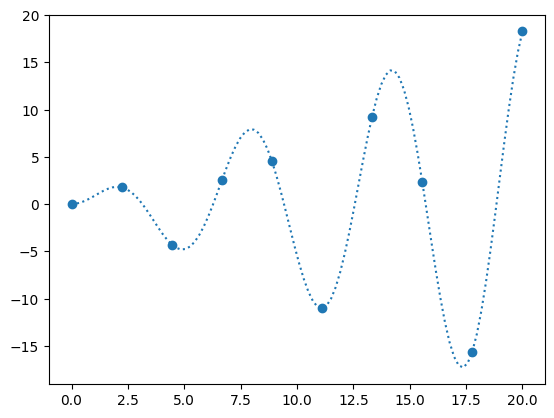

In [18]:
fig, ax = plt.subplots()

x_fine = np.linspace(0, 20, 10*N)

ax.scatter(x, y)
ax.plot(x_fine, f_exact(x_fine), ls=":", label="original function")

When we create an interpolant via `interp1d`, it creates a function object

In [19]:
f_interp = interpolate.interp1d(x, y, kind="cubic")

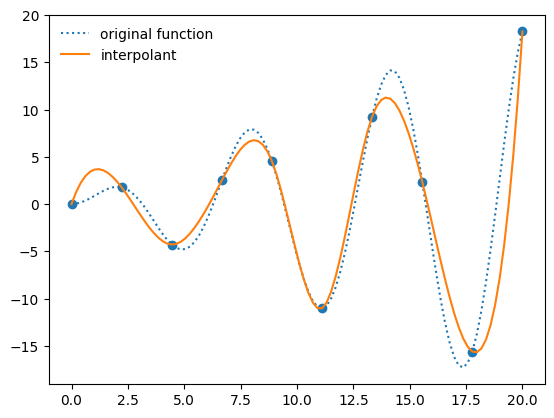

In [20]:
ax.plot(x_fine, f_interp(x_fine), label="interpolant")

ax.legend(frameon=False, loc="best")
fig

### Multi-d interpolation

Here's an example of mult-d interpolation from the official tutorial.

First we define the "answer"---this is the true function that we will sample at a number of points and then try to use interpolation to recover

In [21]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

We'll use `np.meshgrid()` to create the two-dimensional rectangular grid of points were we define our data.

In [22]:
nx = 100
ny = 200

x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)

x, y = np.meshgrid(x, y, indexing="ij")

here's what the exact function looks like---note that our function is defined in x,y, but imshow is meant for plotting an array, so the first index is the row.  We take the transpose when plotting

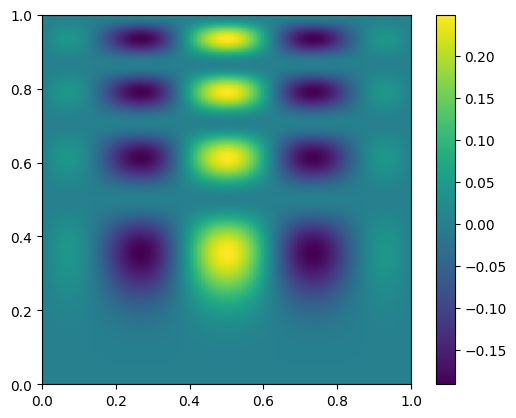

In [23]:
fig, ax = plt.subplots()
data = func(x, y)
im = ax.imshow(data.T, extent=(0, 1, 0, 1), origin="lower")
fig.colorbar(im, ax=ax)

Now we'll coarsen it by taking only every 4th point

In [24]:
coarse = data[::4, ::4]

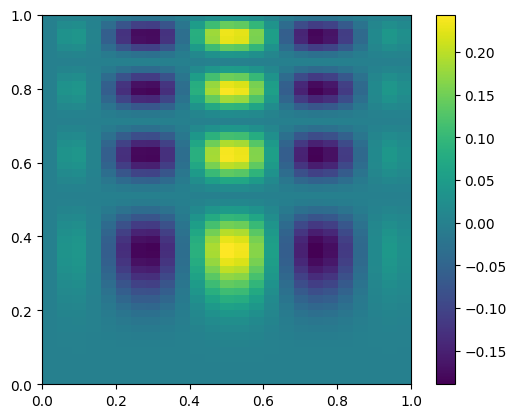

In [25]:
fig, ax = plt.subplots()
im = ax.imshow(coarse.T, extent=(0, 1, 0, 1), origin="lower")
fig.colorbar(im, ax=ax)

Let's now use interpolation to try to recover the look of the original data.

```{note}
This is considered structured grid interpolation, and SciPy has the [RegularGridInterpolator()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html) class for this type of data.

If the data were unstructured, then you should explore [griddata()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) instead.
```

In [26]:
from scipy import interpolate

In [27]:
x_coarse = np.linspace(0, 1, nx//4)
y_coarse = np.linspace(0, 1, ny//4)

interp = interpolate.RegularGridInterpolator((x_coarse, y_coarse), coarse, method="cubic")

Now `interp()` is a function that we can use to sample the coarsened data.

Now interpolate it onto the original grid

In [28]:
new_data = interp((x, y))
new_data.shape

(100, 200)

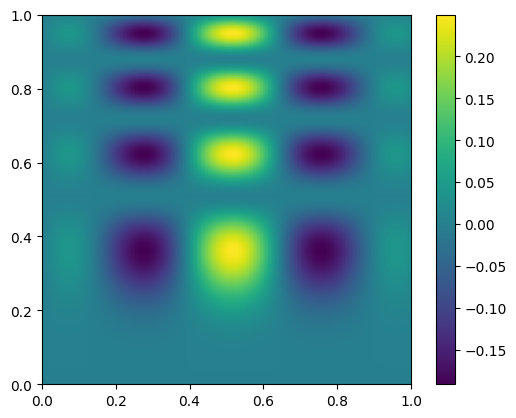

In [29]:
fig, ax = plt.subplots()
im = ax.imshow(new_data.T, extent=(0, 1, 0, 1), origin="lower")
fig.colorbar(im, ax=ax)

and let's plot the difference

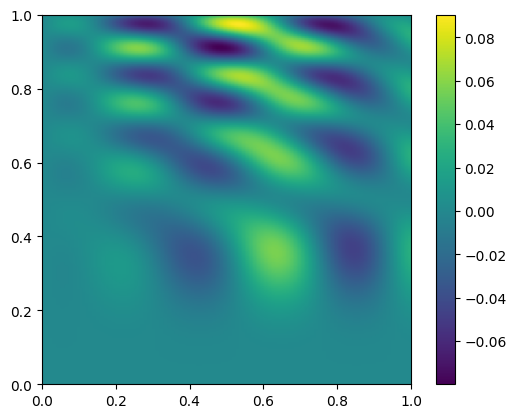

In [30]:
diff = new_data - data
fig, ax = plt.subplots()
im = ax.imshow(diff.T, origin="lower", extent=(0, 1, 0, 1))
fig.colorbar(im, ax=ax)

## Root Finding

Often we need to find a value of a variable that zeros a function -- this is _root finding_.  Sometimes, this is a multidimensional problem.

The [brentq()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html) method offers a very robust method for find roots from a scalar function.  You do need to provide an interval that bounds the root.

```{tip}
It's a good idea to plot the function, if you can, so you can learn how the function behaves
in the vicinity of a root (and how many roots there might be)
```

Let's consider:

$f(x) = \frac{x e^x}{e^x - 1} - 5$

In [31]:
import scipy.optimize as optimize

In [32]:
def f(x):
    return (x*np.exp(x)/(np.exp(x) - 1.0) - 5.0)

In [33]:
root, r = optimize.brentq(f, 0.1, 10.0, full_output=True)

print(root)
print(r.converged)

4.965114231744287
True


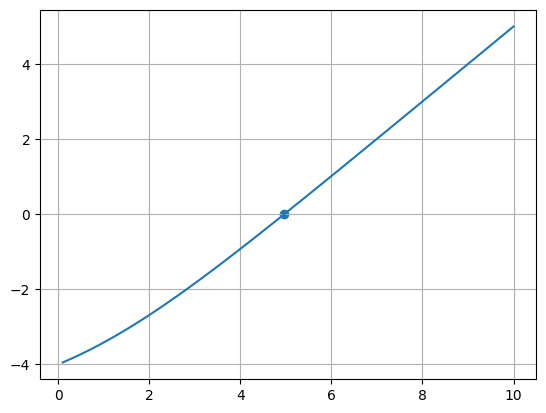

In [34]:
x = np.linspace(0.1, 10.0, 1000)
fig, ax = plt.subplots()
ax.plot(x, f(x))
ax.scatter(np.array([root]), np.array([f(root)]))
ax.grid()

## ODEs

Many methods exist for integrating ordinary differential equations.  Most will want you to write your ODEs as a system of first order equations.

The [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) is a very simple
model of convection in our atmosphere, but demonstrates the idea of chaos well.

This system of ODEs for the Lorenz system is:

$$\frac{dx}{dt} = \sigma (y - x)$$
$$\frac{dy}{dt} = rx - y - xz$$
$$\frac{dz}{dt} = xy - bz$$

the steady states of this system correspond to:

$${\bf f}({\bf x}) = 
\left (
\begin{array}{c}
\sigma (y -x) \\
rx - y -xz \\
xy - bz
\end{array}
\right )
= 0$$


In [35]:
# system parameters
sigma = 10.0
b = 8./3.
r = 28.0

def rhs(t, x):
    xdot = sigma*(x[1] - x[0])
    ydot = r*x[0] - x[1] - x[0]*x[2]
    zdot = x[0]*x[1] - b*x[2]

    return np.array([xdot, ydot, zdot])

def jac(t, x):

    return np.array(
        [ [-sigma, sigma, 0.0], 
          [r - x[2], -1.0, -x[0]],
          [x[1], x[0], -b] ])

def f(x):
    return rhs(0.,x), jac(0.,x)

SciPy has a uniform interface to the different ODE solvers, [solve_ivp()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)---we use that here.

These integrators will do error estimation along the way and adapt the stepsize to ensure that the accuracy
you request is met.

In [36]:
def ode_integrate(X0, dt, tmax):
    """ integrate using the VODE method, storing the solution each dt """

    r = integrate.solve_ivp(rhs, (0.0, tmax), X0,
                            method="RK45", dense_output=True)

    # get the solution at intermediate times
    ts = np.arange(0.0, tmax, dt)
    
    Xs = r.sol(ts)
    return ts, Xs

````{tip}
Execute
```
%matplotlib widget
```
in a cell before making this 3D plot and you will be able to interactively
rotate it in the notebook.

You may need to install the [ipympl](https://matplotlib.org/ipympl/) package first.
````

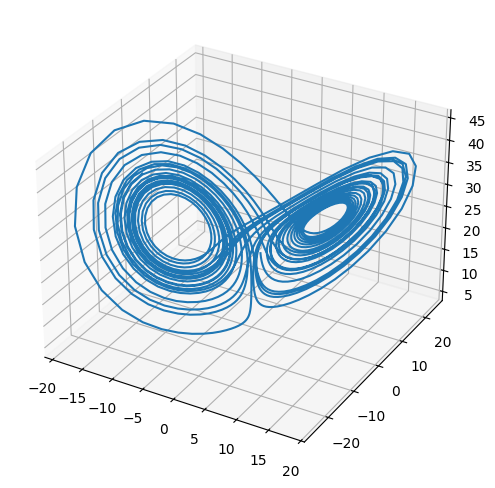

In [37]:
t, X = ode_integrate([1.0, 1.0, 20.0], 0.02, 30)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(X[0,:], X[1,:], X[2,:])
fig.set_size_inches(8.0,6.0)

```{admonition} try it
Rerun the integration, but change the initial conditions by 1 part in $10^6$ for one of the components.
The make a plot of $x$ vs. $t$ comparing the solutions.  You'll see that the 2 solutions track well
for some time but then greatly diverged.  This is the sensitivity to initial conditions that is the
hallmark of chaos.
```

### Multi-variate root find

We can find the steady points in this system by doing a multi-variate root find on the RHS vector

In [38]:
sol1 = optimize.root(f, [1., 1., 1.], jac=True)
print(sol1.x)

sol2 = optimize.root(f, [10., 10., 10.], jac=True)
print(sol2.x)

sol3 = optimize.root(f, [-10., -10., -10.], jac=True)
print(sol3.x)

[0. 0. 0.]
[ 8.48528137  8.48528137 27.        ]
[-8.48528137 -8.48528137 27.        ]


Text(0.5, 0, 'z')

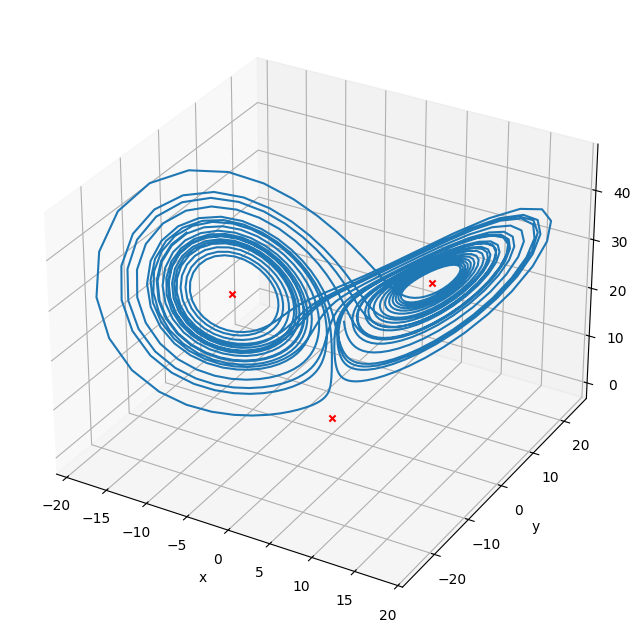

In [39]:
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

ax.plot(X[0,:], X[1,:], X[2,:])

ax.scatter(sol1.x[0], sol1.x[1], sol1.x[2], marker="x", color="r")
ax.scatter(sol2.x[0], sol2.x[1], sol2.x[2], marker="x", color="r")
ax.scatter(sol3.x[0], sol3.x[1], sol3.x[2], marker="x", color="r")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

### Stiff system of ODEs

A stiff system of ODEs is one where there are multiple disparate timescales for change and we need to respect all of them to get an accurate solution

Here is an example from Chemical Kinetics (see, ex. Byrne & Hindmarsh 1986, or the VODE source code)

$$
\frac{d}{dt} \left (
   \begin{array}{c} y_1 \newline y_2 \newline y_3 \end{array}
  \right ) =
%
\left (
 \begin{array}{rrr}
  -0.04 y_1 & + 10^4 y_2 y_3  & \newline
   0.04 y_1 & - 10^4 y_2 y_3 & -3\times 10^7 y_2^2 \newline
   &  & 3\times 10^7 y_2^2 
\end{array}
\right )
$$

$$
{\bf J} = \left (
\begin{array}{ccc}
  -0.04 & 10^4 y_3 & 10^4 y_2 \newline
   0.04 & -10^4 y_3 - 6\times 10^7 y_2 & -10^4 y_2 \newline
   0 & 6\times 10^7 y_2 & 0 
\end{array}
\right )
$$

start with $y_1(0) = 1, y_2(0) = y_3(0) = 0$.  Long term behavior is $y_1, y_2 \rightarrow 0; y_3 \rightarrow 1$

In [40]:
def rhs(t, Y):
    """ RHS of the system -- using 0-based indexing """
    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]

    dy1dt = -0.04*y1 + 1.e4*y2*y3
    dy2dt =  0.04*y1 - 1.e4*y2*y3 - 3.e7*y2**2
    dy3dt =                         3.e7*y2**2

    return np.array([dy1dt, dy2dt, dy3dt])

def jac(t, Y):
    """ J_{i,j} = df_i/dy_j """

    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]

    df1dy1 = -0.04
    df1dy2 = 1.e4*y3
    df1dy3 = 1.e4*y2

    df2dy1 = 0.04
    df2dy2 = -1.e4*y3 - 6.e7*y2
    df2dy3 = -1.e4*y2

    df3dy1 = 0.0
    df3dy2 = 6.e7*y2
    df3dy3 = 0.0

    return np.array([ [ df1dy1, df1dy2, df1dy3 ],
                      [ df2dy1, df2dy2, df2dy3 ],
                      [ df3dy1, df3dy2, df3dy3 ] ])

In [41]:
def vode_integrate(Y0, tmax):
    """ integrate using the NDF method """

    r = integrate.solve_ivp(rhs, (0.0, tmax), Y0,
                            method="BDF", jac=jac, rtol=1.e-7, atol=1.e-10)

    # Note: this solver does not have a dens_output method, instead we 
    # access the solution data where it was evaluated internally via
    # the return object
    
    return r.t, r.y

Text(0.5, 0, 'time')

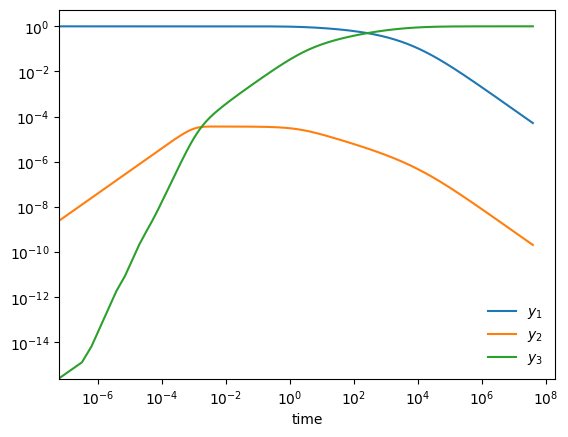

In [42]:
Y0 = np.array([1.0, 0.0, 0.0])
tmax = 4.e7

ts, Ys = vode_integrate(Y0, tmax)

fig, ax = plt.subplots()
ax.loglog(ts, Ys[0,:], label=r"$y_1$")
ax.loglog(ts, Ys[1,:], label=r"$y_2$")
ax.loglog(ts, Ys[2,:], label=r"$y_3$")

ax.legend(loc="best", frameon=False)
ax.set_xlabel("time")

```{admonition} try it
Redo this integration, but now use the `RK45` solver instead of `BDF`.  Does it work?

You may need to use the `kernel` menu in Jupyter to interrupt the kernel if you get impatient.
```